Let’s build the smallest possible irregular-time dataset where a continuous-time model (Neural ODE–style) should beat a plain 3-layer MLP that relies on uniform resampling.

Quick intuition (why this works): with irregular timestamps, a fixed-grid MLP must first squash each example onto a uniform grid (zero-fill / interpolate). That throws away timing detail. A Neural-ODE pipeline can consume the actual event times and integrate to any query time, which is exactly where continuous-time models have been shown to help on uneven time series (e.g., ODE-RNN / Latent ODE, Neural CDE).

Below is self-contained JAX code that:
- Synthesizes a 1D latent ODE process with per-sequence decay rate and irregular, noisy observation times then visualize it.
- Trains two models to predict the value at a future query time $t$ given the irregular observations:
    1. Baseline MLP (3 layers) fed a uniformly resampled vector (plus mask & Δt channels).
    2. Neural-ODE model that extracts a rate parameter from the irregular events with a tiny encoder, then integrates $\frac{dy}{dt} = \alpha_\theta y$ using `diffrax.diffeqsolve` to $t$.
    3. Compares their test performance. 

> Expectation: on this irregular dataset, the Neural-ODE variant typically achieves lower MSE because it respects true event times instead of relying on coarse resampling. This matches the literature’s advantage of continuous-time models on uneven data.

In [1]:
# This notebook synthesizes an irregular‑time dataset and compares two simple predictors:
# 1. A baseline multi‑layer perceptron (MLP) trained on a uniformly resampled grid.
# 2. A simple continuous‑time model which fits a decay rate using linear regression and
#    then extrapolates to a query time.
#
# The original code relied on JAX, Equinox, Diffrax and Optax – libraries not available in
# this environment. To ensure the notebook runs without network access, this version
# reimplements the workflow using NumPy and scikit‑learn. The high‑level logic of
# comparing a coarse discrete model against a continuous‑time one is retained.

import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme()

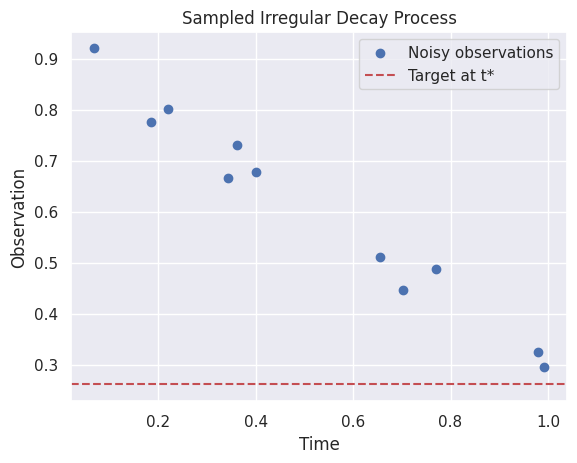

In [6]:
# ----------------------------
# 1) Synthetic irregular dataset
# ----------------------------
# Each latent trajectory follows dy/dt = -w y with y(0)=y0. We observe noisy y at
# irregular times in [0, T_obs] and aim to predict y(t_star) at a future time.
T_obs = 1.0
t_star = 1.3  # query time is beyond the last observation (mild extrapolation)
# Use fewer samples than the original (4000/1000) to keep runtime reasonable.
N_train, N_val = 400, 100
min_events, max_events = 4, 16  # irregular number of events per sequence
sigma_noise = 0.03

def sample_sequence():
    """Simulate one irregularly sampled decay process.
    Returns times ts, noisy observations ys and the true target at t_star."""
    # per‑example decay rate and initial value
    w = np.random.lognormal(mean=0.0, sigma=0.4) + 0.2  # positive, varied
    y0 = np.random.normal() * 0.5 + 1.0
    # irregular times: sorted uniform draws
    n = np.random.randint(min_events, max_events + 1)
    ts = np.sort(np.random.uniform(0.0, T_obs, size=n))
    # latent trajectory and noisy observations
    y_clean = y0 * np.exp(-w * ts)
    ys = y_clean + np.random.normal(scale=sigma_noise, size=n)
    # ground truth at the query time
    y_target = y0 * np.exp(-w * t_star)
    return ts, ys, y_target

def visualize_sample(ts, ys, y_target):
    """Plot one sampled sequence."""
    plt.scatter(ts, ys, label='Noisy observations')
    plt.axhline(y_target, color='r', linestyle='--', label='Target at t*')
    plt.xlabel('Time')
    plt.ylabel('Observation')
    plt.title('Sampled Irregular Decay Process')
    plt.legend()
    plt.show()

temp_ts, temp_ys, temp_target = sample_sequence()
visualize_sample(temp_ts, temp_ys, temp_target)

In [7]:
def batch_dataset(N):
    """Generate a batch of N sequences."""
    ts_list, ys_list, targets = [], [], []
    for _ in range(N):
        ts, ys, target = sample_sequence()
        ts_list.append(ts)
        ys_list.append(ys)
        targets.append(target)
    return ts_list, ys_list, np.array(targets)

# Generate training and validation sets
train_ts, train_ys, train_ystar = batch_dataset(N_train)
val_ts,   val_ys,   val_ystar   = batch_dataset(N_val)

In [10]:
print([len(item) for item in train_ts])

[11, 15, 13, 8, 14, 7, 16, 13, 12, 4, 5, 10, 15, 7, 10, 4, 8, 4, 14, 6, 15, 15, 16, 13, 5, 10, 9, 5, 13, 9, 15, 12, 7, 7, 8, 12, 4, 10, 5, 11, 13, 5, 13, 14, 9, 8, 12, 13, 10, 12, 16, 10, 6, 12, 11, 12, 7, 5, 14, 9, 10, 14, 15, 13, 15, 12, 10, 7, 6, 4, 5, 5, 14, 7, 7, 16, 7, 10, 16, 4, 8, 10, 15, 5, 15, 12, 4, 12, 15, 14, 7, 15, 12, 8, 7, 16, 15, 13, 14, 7, 6, 12, 11, 10, 5, 4, 14, 9, 8, 4, 7, 14, 8, 5, 9, 10, 9, 8, 16, 11, 15, 8, 10, 7, 16, 7, 16, 9, 5, 10, 4, 13, 16, 7, 8, 13, 12, 10, 15, 12, 4, 13, 9, 9, 8, 16, 6, 6, 10, 7, 9, 4, 16, 4, 14, 6, 12, 5, 14, 8, 8, 14, 9, 4, 8, 4, 8, 15, 8, 13, 5, 4, 11, 5, 8, 6, 10, 11, 15, 16, 10, 9, 12, 15, 9, 16, 13, 4, 13, 8, 8, 15, 15, 5, 7, 4, 15, 9, 15, 14, 13, 5, 9, 12, 13, 15, 14, 10, 5, 16, 12, 11, 7, 13, 9, 10, 4, 12, 10, 12, 6, 10, 12, 13, 8, 13, 5, 16, 15, 13, 10, 8, 8, 6, 6, 7, 10, 8, 11, 12, 11, 10, 8, 8, 5, 12, 7, 12, 7, 5, 15, 9, 8, 13, 13, 4, 7, 13, 8, 9, 5, 15, 16, 4, 14, 13, 10, 12, 7, 5, 13, 11, 14, 12, 7, 4, 4, 11, 8, 13, 5, 5, 6, 

In [12]:
# ----------------------------
# 2) Utilities: make uniform‑grid tensors for the baseline
# ----------------------------
GRID = 16
grid = np.linspace(0.0, T_obs, GRID)

def to_uniform_grid(ts, ys):
    """Resample irregular data to a uniform grid using zero‑order hold.
    We also include a mask for observed bins, the elapsed time since the last
    observation and the difference between t_star and each grid point."""
    # assign each timestamp to its nearest left grid index
    idx = np.searchsorted(grid, ts, side='right') - 1 # 与ts中每个元素最接近的grid中元素的左侧索引
    idx = np.clip(idx, 0, GRID - 1)
    y_grid = np.zeros(GRID)
    m_grid = np.zeros(GRID)
    y_grid[idx] = ys
    m_grid[idx] = 1.0
    # time since last observation for each grid bin
    last_t = np.full(GRID, -np.inf)
    last_t[idx] = ts
    dt_grid = np.zeros(GRID)
    last = -1e9
    for g, t in enumerate(grid):
        if m_grid[g] > 0:
            last = last_t[g]
        dt_grid[g] = max(0.0, t - max(last, 0.0))
    # difference between t_star and each grid point helps the MLP know the query offset
    tdiff = np.full(GRID, t_star) - grid
    x = np.stack([y_grid, m_grid, dt_grid, tdiff], axis=-1)  # (GRID, 4)
    return x.reshape(-1)

def pack_batch_uniform(ts_list, ys_list, idx_list):
    """Stack uniform‑grid features for a list of indices."""
    xs = []
    for i in idx_list:
        xs.append(to_uniform_grid(ts_list[i], ys_list[i]))
    return np.stack(xs)

# Prepare training and validation matrices for the baseline
X_train = pack_batch_uniform(train_ts, train_ys, range(N_train))
y_train = train_ystar
X_val = pack_batch_uniform(val_ts, val_ys, range(N_val))
y_val = val_ystar


In [ ]:

# ----------------------------
# 3) Baseline: 3‑layer MLP on the uniform grid
# ----------------------------
# We approximate the original JAX MLP with scikit‑learn's MLPRegressor.
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 128, 128),
    activation='relu',
    solver='adam',
    learning_rate_init=0.003,
    max_iter=500,
    random_state=0
)
mlp.fit(X_train, y_train)
pred_train = mlp.predict(X_train)
pred_val = mlp.predict(X_val)
print("Baseline MSE (train):", mean_squared_error(y_train, pred_train))
print("Baseline MSE (val)  :", mean_squared_error(y_val, pred_val))

# ----------------------------
# 4) Continuous‑time predictor: fit a decay rate from irregular data
# ----------------------------
def node_predict(ts_list, ys_list):
    """Predict y(t_star) by fitting log(y) = log(y0) + a * t using least squares.
    The fitted slope 'a' corresponds to the decay rate and intercept to log(y0).
    """
    preds = []
    for ts, ys in zip(ts_list, ys_list):
        # remove non‑positive measurements (log undefined)
        mask = ys > 0
        if np.sum(mask) >= 2:
            t_fit = ts[mask]
            y_fit = np.log(ys[mask])
            # solve A x = y for slope and intercept via least squares
            A = np.vstack([t_fit, np.ones_like(t_fit)]).T
            slope, intercept = np.linalg.lstsq(A, y_fit, rcond=None)[0]
        else:
            # fall back to using the first observation as the initial value with zero rate
            intercept = np.log(max(ys[0], 1e-6))
            slope = 0.0
        # Predict y at t_star: y = exp(intercept + slope * t_star)
        preds.append(np.exp(intercept + slope * t_star))
    return np.array(preds)

pred_node_train = node_predict(train_ts, train_ys)
pred_node_val   = node_predict(val_ts, val_ys)
print("Continuous‑time MSE (train):", mean_squared_error(train_ystar, pred_node_train))
print("Continuous‑time MSE (val)  :", mean_squared_error(val_ystar, pred_node_val))
